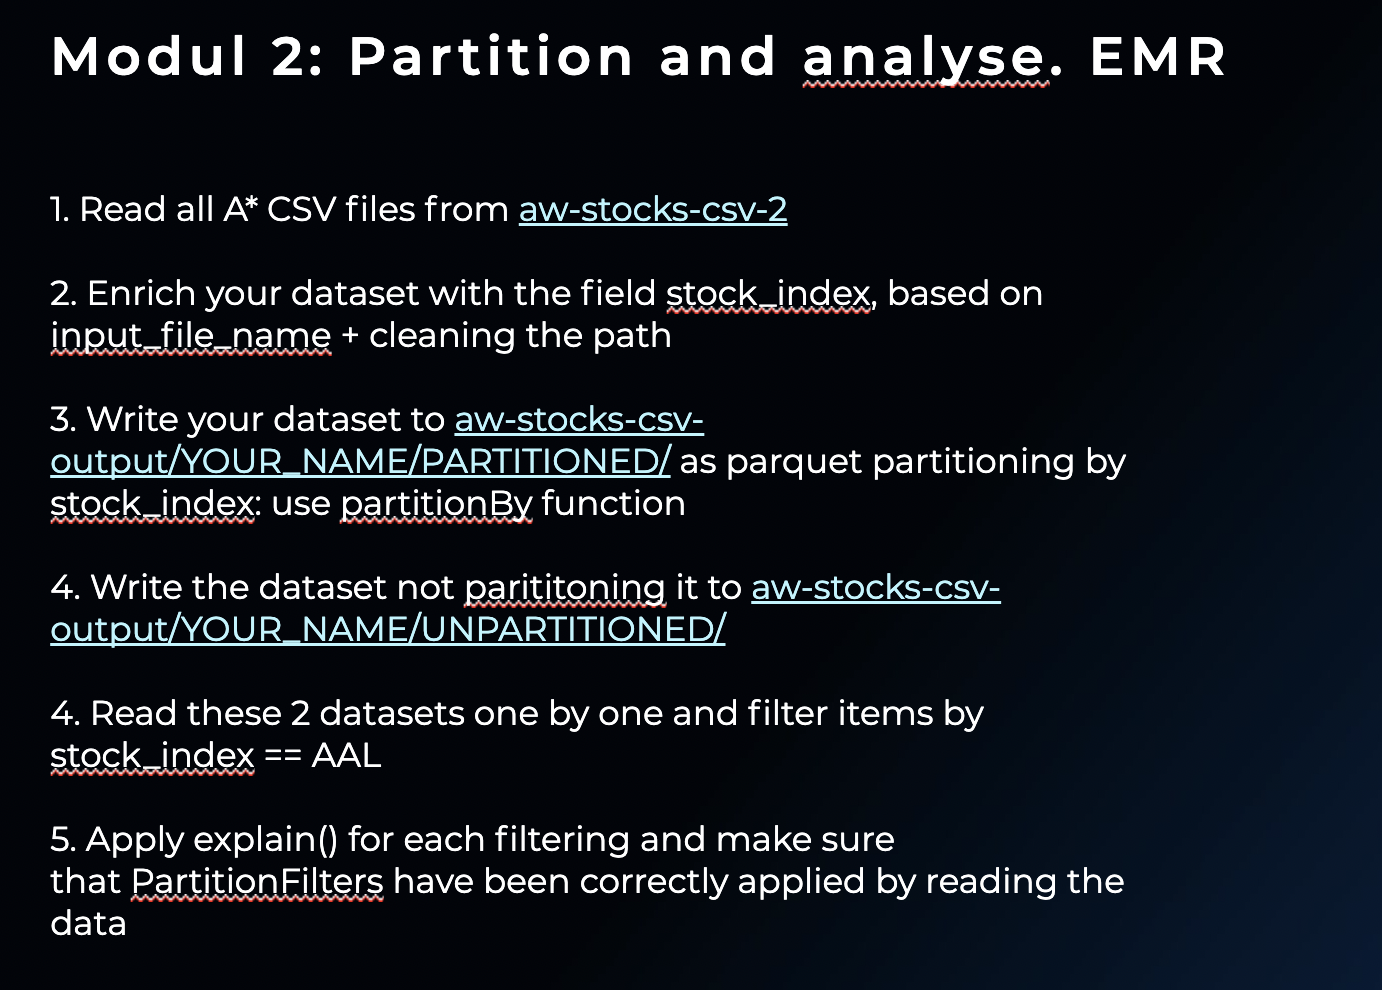

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
6,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
spark = SparkSession.builder.master("local[1]").appName("Spark").getOrCreate()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 1. Read all A* files from aws-stocks-csv-2

In [3]:
df = spark.read.option("header","true").csv("s3://aw-stocks-csv-2/A*.csv")
df.show(5, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------------+-------------------+---------+-------------------+-------------------+-------------------+
|Date      |Low                |Open               |Volume   |High               |Close              |Adjusted Close     |
+----------+-------------------+-------------------+---------+-------------------+-------------------+-------------------+
|12-12-1980|0.1283479928970337 |0.1283479928970337 |469033600|0.1289059966802597 |0.1283479928970337 |0.10003948211669922|
|15-12-1980|0.12165199965238571|0.12221000343561172|175884800|0.12221000343561172|0.12165199965238571|0.09482034295797348|
|16-12-1980|0.11272300034761429|0.1132809966802597 |105728000|0.1132809966802597 |0.11272300034761429|0.08786075562238693|
|17-12-1980|0.11551299691200256|0.11551299691200256|86441600 |0.11607100069522858|0.11551299691200256|0.09003540128469467|
|18-12-1980|0.11886200308799744|0.11886200308799744|73449600 |0.11941999942064285|0.11886200308799744|0.09264572709798813|
+----------+----

### 2. Adding stock_index and cleaning path

In [10]:
df1 = df.withColumn("stock_index", input_file_name())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
df1.select('stock_index').show(5,truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------------+
|stock_index                  |
+-----------------------------+
|s3://aw-stocks-csv-2/AAPL.csv|
|s3://aw-stocks-csv-2/AAPL.csv|
|s3://aw-stocks-csv-2/AAPL.csv|
|s3://aw-stocks-csv-2/AAPL.csv|
|s3://aw-stocks-csv-2/AAPL.csv|
+-----------------------------+
only showing top 5 rows

In [12]:
df1 = df1.withColumn('stock_index', regexp_replace('stock_index', 's3://aw-stocks-csv-2/', ''))
df1 = df1.withColumn('stock_index', regexp_replace('stock_index', '.csv', '')) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
df1.select('stock_index').show(5,truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|stock_index|
+-----------+
|AAPL       |
|AAPL       |
|AAPL       |
|AAPL       |
|AAPL       |
+-----------+
only showing top 5 rows

In [10]:
# df1 = df1.filter(df1.stock_index.startswith("A"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
df1 = df1.withColumnRenamed("Adjusted Close", "Adjusted_close")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
df1.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------------+-------------------+---------+-------------------+-------------------+-------------------+-----------+
|      Date|                Low|               Open|   Volume|               High|              Close|     Adjusted_close|stock_index|
+----------+-------------------+-------------------+---------+-------------------+-------------------+-------------------+-----------+
|12-12-1980| 0.1283479928970337| 0.1283479928970337|469033600| 0.1289059966802597| 0.1283479928970337|0.10003948211669922|       AAPL|
|15-12-1980|0.12165199965238571|0.12221000343561172|175884800|0.12221000343561172|0.12165199965238571|0.09482034295797348|       AAPL|
|16-12-1980|0.11272300034761429| 0.1132809966802597|105728000| 0.1132809966802597|0.11272300034761429|0.08786075562238693|       AAPL|
|17-12-1980|0.11551299691200256|0.11551299691200256| 86441600|0.11607100069522858|0.11551299691200256|0.09003540128469467|       AAPL|
|18-12-1980|0.11886200308799744|0.11886200308799744| 73

### 3. Write your dataset to aw-stocks-csv-output/YOUR_NAME/PARTITIONED/ as parquet partitioning by stock_index: use partitionBy function

In [21]:
df1.write\
    .option('encoding', 'UTF-8')\
    .partitionBy('stock_index')\
    .parquet("s3://aw-stocks-csv-output/attila/PARTITIONED/stocks.parquet")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4. Write your unpartitioned dataset to aw-stocks-csv-output/YOUR_NAME/UNPARTITIONED/

In [14]:
df1.write\
    .option('encoding', 'UTF-8')\
    .mode("overwrite")\
    .parquet("s3://aw-stocks-csv-output/attila/UNPARTITIONED/stocks.parquet")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 5. Read these  2 datasets one by one and filter items by stock_index == AAL

In [22]:
df_p = spark.read.parquet('s3://aw-stocks-csv-output/attila/PARTITIONED/stocks.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
df_p.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------------------+----+-------+------------------+------------------+-------------------+-----------+
|      Date|               Low|Open| Volume|              High|             Close|     Adjusted_close|stock_index|
+----------+------------------+----+-------+------------------+------------------+-------------------+-----------+
|17-03-1980|0.8085539937019348| 0.0|1158040|0.8271409869194031|0.8178470134735107|0.42267295718193054|        ADP|
|18-03-1980| 0.814749002456665| 0.0|1622063|0.8302389979362488|0.8271409869194031|0.42747625708580017|        ADP|
|19-03-1980|0.8271409869194031| 0.0|1367859|0.8426309823989868|0.8426309823989868| 0.4354817867279053|        ADP|
|20-03-1980|0.8395329713821411| 0.0|3046412|0.8612179756164551|0.8395329713821411|0.43388083577156067|        ADP|
|21-03-1980|0.8364350199699402| 0.0|1020851| 0.848825991153717|0.8364350199699402|  0.432279497385025|        ADP|
+----------+------------------+----+-------+------------------+-----------------

In [15]:
df_up = spark.read.parquet('s3://aw-stocks-csv-output/attila/UNPARTITIONED/stocks.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
df_up.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------------+-------------------+---------+-------------------+-------------------+-------------------+-----------+
|      Date|                Low|               Open|   Volume|               High|              Close|     Adjusted_close|stock_index|
+----------+-------------------+-------------------+---------+-------------------+-------------------+-------------------+-----------+
|12-12-1980| 0.1283479928970337| 0.1283479928970337|469033600| 0.1289059966802597| 0.1283479928970337|0.10003948211669922|       AAPL|
|15-12-1980|0.12165199965238571|0.12221000343561172|175884800|0.12221000343561172|0.12165199965238571|0.09482034295797348|       AAPL|
|16-12-1980|0.11272300034761429| 0.1132809966802597|105728000| 0.1132809966802597|0.11272300034761429|0.08786075562238693|       AAPL|
|17-12-1980|0.11551299691200256|0.11551299691200256| 86441600|0.11607100069522858|0.11551299691200256|0.09003540128469467|       AAPL|
|18-12-1980|0.11886200308799744|0.11886200308799744| 73

In [24]:
df_p_filter = df_p.where(col('stock_index') == "AAL")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
df_p_filter.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------------------+------------------+-------+------------------+------------------+------------------+-----------+
|      Date|               Low|              Open| Volume|              High|             Close|    Adjusted_close|stock_index|
+----------+------------------+------------------+-------+------------------+------------------+------------------+-----------+
|27-09-2005|19.100000381469727|21.049999237060547| 961200|21.399999618530273|19.299999237060547|18.194910049438477|        AAL|
|28-09-2005|19.200000762939453|19.299999237060547|5747900|20.530000686645508|              20.5|19.326204299926758|        AAL|
|29-09-2005|20.100000381469727|20.399999618530273|1078200|20.579999923706055|20.209999084472656| 19.05280303955078|        AAL|
|30-09-2005| 20.18000030517578|20.260000228881836|3123300|21.049999237060547|21.010000228881836|19.806997299194336|        AAL|
|03-10-2005|20.899999618530273|20.899999618530273|1057900|             21.75|              21.5|20.26893

In [17]:
df_up_filter = df_up.where(col('stock_index') == "AAL")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
df_up_filter.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------------------+------------------+-------+------------------+------------------+------------------+-----------+
|      Date|               Low|              Open| Volume|              High|             Close|    Adjusted_close|stock_index|
+----------+------------------+------------------+-------+------------------+------------------+------------------+-----------+
|27-09-2005|19.100000381469727|21.049999237060547| 961200|21.399999618530273|19.299999237060547|18.194910049438477|        AAL|
|28-09-2005|19.200000762939453|19.299999237060547|5747900|20.530000686645508|              20.5|19.326204299926758|        AAL|
|29-09-2005|20.100000381469727|20.399999618530273|1078200|20.579999923706055|20.209999084472656| 19.05280303955078|        AAL|
|30-09-2005| 20.18000030517578|20.260000228881836|3123300|21.049999237060547|21.010000228881836|19.806997299194336|        AAL|
|03-10-2005|20.899999618530273|20.899999618530273|1057900|             21.75|              21.5|20.26893

### 6. Apply explain() for each filtering and make sure that PartitionFilters have been correctly applied by reading the data 

In [ ]:
# https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.explain.html

In [27]:
df_p.where(col('stock_index') == "AAL").explain(extended=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

== Parsed Logical Plan ==
'Filter ('stock_index = AAL)
+- Relation[Date#273,Low#274,Open#275,Volume#276,High#277,Close#278,Adjusted_close#279,stock_index#280] parquet

== Analyzed Logical Plan ==
Date: string, Low: string, Open: string, Volume: string, High: string, Close: string, Adjusted_close: string, stock_index: string
Filter (stock_index#280 = AAL)
+- Relation[Date#273,Low#274,Open#275,Volume#276,High#277,Close#278,Adjusted_close#279,stock_index#280] parquet

== Optimized Logical Plan ==
Filter (isnotnull(stock_index#280) && (stock_index#280 = AAL))
+- Relation[Date#273,Low#274,Open#275,Volume#276,High#277,Close#278,Adjusted_close#279,stock_index#280] parquet

== Physical Plan ==
*(1) FileScan parquet [Date#273,Low#274,Open#275,Volume#276,High#277,Close#278,Adjusted_close#279,stock_index#280] Batched: true, Format: Parquet, Location: InMemoryFileIndex[s3a://aw-stocks-csv-output/attila/PARTITIONED/stocks.parquet], PartitionCount: 1, PartitionFilters: [isnotnull(stock_index#280), (

In [20]:
df_up.where(col('stock_index') == "AAL").explain(extended=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

== Parsed Logical Plan ==
'Filter ('stock_index = AAL)
+- Relation[Date#192,Low#193,Open#194,Volume#195,High#196,Close#197,Adjusted_close#198,stock_index#199] parquet

== Analyzed Logical Plan ==
Date: string, Low: string, Open: string, Volume: string, High: string, Close: string, Adjusted_close: string, stock_index: string
Filter (stock_index#199 = AAL)
+- Relation[Date#192,Low#193,Open#194,Volume#195,High#196,Close#197,Adjusted_close#198,stock_index#199] parquet

== Optimized Logical Plan ==
Filter (isnotnull(stock_index#199) && (stock_index#199 = AAL))
+- Relation[Date#192,Low#193,Open#194,Volume#195,High#196,Close#197,Adjusted_close#198,stock_index#199] parquet

== Physical Plan ==
*(1) Project [Date#192, Low#193, Open#194, Volume#195, High#196, Close#197, Adjusted_close#198, stock_index#199]
+- *(1) Filter (isnotnull(stock_index#199) && (stock_index#199 = AAL))
   +- *(1) FileScan parquet [Date#192,Low#193,Open#194,Volume#195,High#196,Close#197,Adjusted_close#198,stock_index#199] 